### Imports

In [83]:
import importlib
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import modules.data_processing

In [81]:
importlib.reload(modules.data_processing)
from modules.data_processing import *

In [82]:
DATA_PATH = './data/wiki-RfA.txt'

### Extracting Dataset

In [4]:
wiki_df = extract_data(DATA_PATH)

In [5]:
wiki_df.head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


### Data Pre-processing

Before we start processing data, we need to look at what our parsed dataset looks like in order to use the correct types and to fix any noticebly inconsistent values.

In [6]:
wiki_df.shape

(198275, 7)

In [7]:
wiki_df.columns.values

array(['SRC', 'TGT', 'VOT', 'RES', 'YEA', 'DAT', 'TXT'], dtype=object)

In [8]:
wiki_df[wiki_df['SRC'] == ''].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
707,,Jason Quinn,0,1,2013,,
708,,Jason Quinn,0,1,2013,,
793,,Legoktm,1,1,2013,,
1126,,Mattythewhite,-1,1,2013,,
1128,,Mattythewhite,-1,1,2013,,


We notice there are occurences where the SRC is empty, we replace those occurences by null values.

In [9]:
wiki_df['DAT'].replace('', np.nan, inplace=True)
wiki_df['SRC'].replace('', np.nan, inplace=True)

Now, let us appropriately format the data in the different columns.

In [10]:
wiki_df[['VOT', 'RES', 'YEA']] = wiki_df[['VOT', 'RES', 'YEA']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# To make it easy to manipulate (summing the ones to get number of votes)
wiki_df['RES'] = wiki_df['RES'].apply(lambda x: 1 if x == 1 else 0 )


Before formatting the date column, we need to look at which columns do not have a consistent date.

In [11]:
inconsistent_dates = pd.to_datetime(wiki_df['DAT'], format='mixed', errors='coerce').isna() & (~wiki_df['DAT'].isna())

wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,"14:47, 1 Julu 2012",'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,"20:44, 3 Janry 2010",'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,"31:29, 24 May 2008",Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,"17:44, 26 Mya 2007",'''Support''' You've been doing a great job wi...


We will fix these dates one by one.

In [12]:
wiki_df['DAT'] = pd.to_datetime(wiki_df['DAT'], format='mixed', errors='coerce')
wiki_df.at[6821, 'DAT'] = pd.to_datetime('2012-07-01 14:47')
wiki_df.at[27608, 'DAT'] = pd.to_datetime('2010-01-03 20:44')
wiki_df.at[116963, 'DAT'] = pd.to_datetime('2007-05-26 14:47')

In [13]:
wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,2012-07-01 14:47:00,'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,2010-01-03 20:44:00,'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,NaT,Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,2007-05-26 14:47:00,'''Support''' You've been doing a great job wi...


The only remaining issue is with the row n° 70591, the date shows "31:29" which is an invalid hour, in order to fix this issue, we need to look at neighboring votes, as they're sorted mainly chronologically, to infer the correct value.

In [14]:
wiki_df.loc[70589:70593]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
70589,Bhadani,Werdna,1,1,2008,2008-05-24 03:13:00,'''Support''': --
70590,Shanel,Werdna,1,1,2008,2008-05-24 03:18:00,'''Support'''. I have known Werdna for about 1...
70591,Pathoschild,Werdna,1,1,2008,NaT,Support because Shanel told me too. <small>(Gi...
70592,Swatjester,Werdna,1,1,2008,2008-05-24 03:37:00,'''Support''' per lolcat.
70593,KnowledgeOfSelf,Werdna,1,1,2008,2008-05-24 04:37:00,'''Support''' Yes please.


Looking at this, it seems that "31:29" most likely was supposed to be "03:29", we will manually fix this error.

In [15]:
wiki_df.at[70591, 'DAT'] = pd.to_datetime('2008-05-24 03:29')

Finally :

In [16]:
wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,2012-07-01 14:47:00,'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,2010-01-03 20:44:00,'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,2008-05-24 03:29:00,Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,2007-05-26 14:47:00,'''Support''' You've been doing a great job wi...


### Exploring Dataset and fixing inconsistencies

Our dataset contains 7 columns for now, we will explore each columns seperately to try to find inconsistencies and to adopt the relevant way of fixing them.

#### SRC & TGT

In this section, we respond to multiple questions about the data that may help us later on when dealing with it.

##### Missing data

The first question is whether there is any missing data in those columns, and what is the reason for the data being missing? If we can answer those questions, we'll be able to more effectively process the data and thus will avoid encountering problems later on when using the data.

In [17]:
empty_or_null_src = wiki_df[pd.isna(wiki_df['SRC'])]
non_empty_or_null_src = wiki_df[~pd.isna(wiki_df['SRC'])]
display(empty_or_null_src)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
707,NaN,Jason Quinn,0,1,2013,NaT,
708,NaN,Jason Quinn,0,1,2013,NaT,
793,NaN,Legoktm,1,1,2013,NaT,
1126,NaN,Mattythewhite,-1,1,2013,NaT,
1128,NaN,Mattythewhite,-1,1,2013,NaT,
...,...,...,...,...,...,...,...
198052,NaN,Yelyos,1,0,2004,NaT,
198116,NaN,Christopher Mahan,1,1,2003,NaT,
198171,NaN,Jwrosenzweig,1,1,2003,NaT,
198217,NaN,Patrick,1,1,2003,NaT,


In [18]:
empty_or_null_tgt = wiki_df[pd.isna(wiki_df['TGT']) | (wiki_df['TGT'] == '')]
display(empty_or_null_tgt)

,SRC,TGT,VOT,RES,YEA,DAT,TXT


In [19]:
print(f'Number of missing data for SRC column: {len(empty_or_null_src)}')
print(f'Number of missing data for TGT column: {len(empty_or_null_tgt)}')

Number of missing data for SRC column: 1661
Number of missing data for TGT column: 0


We notice that for rows where the SRC value is missing, the TXT value seems to also be missing, let's see if this is the case for all the rows.

In [20]:
empty_or_null_src_txt = empty_or_null_src[pd.isna(empty_or_null_src['TXT']) | (empty_or_null_src['TXT'] == '')]
print(f'Number of missing data for TXT column when SRC is missing: {len(empty_or_null_src_txt)}')

Number of missing data for TXT column when SRC is missing: 1661


We thus find that all the rows where the SRC value is missing, also have the TXT value as missing. Let's now see if the same holds for the DAT value.

In [21]:
empty_or_null_src_dat = empty_or_null_src[pd.isna(empty_or_null_src['DAT'])]
print(f'Number of missing data for DAT column when SRC is missing: {len(empty_or_null_src_dat)}')

Number of missing data for DAT column when SRC is missing: 1661


Thus, whenever the SRC value is missing, the DAT and TXT values are also missing.
The first answer that comes to mind is that might because of an error in the parsing of the file, however, a manual verification leads to the realisation that there are indeed missing values for the SRC attribute.

Let us explore this missing data to see if we can extract any information from it.

First thing we will do is plot the indexes of the missing data, as this can inform us on when missing data happens and whether it has something to do with the ordering in the file.

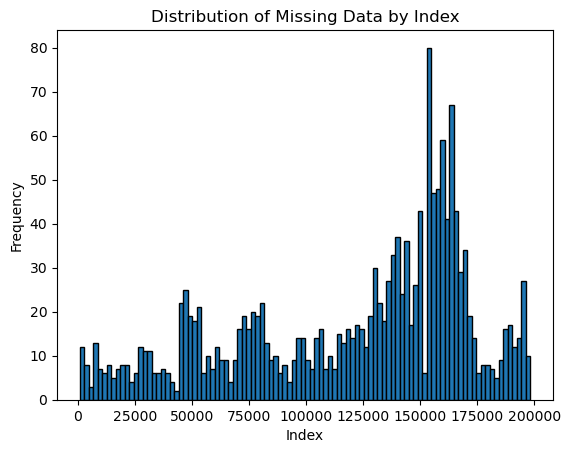

In [22]:
indexes = empty_or_null_src.index

plt.hist(indexes, bins=100, edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Data by Index')
plt.show()

We can see there is a higher concentration of missing data towards the end of the file, between index 150 000 and index 170 000, signaling there might be a problem with the data in that region of the file. However, we cannot draw conclusions as it can be that missing data is more frequent for a certain year, and that that year is located in that region of the file, for instance.

Which is why we also need to plot the distribution of the missing data throughout the years the voting happens.

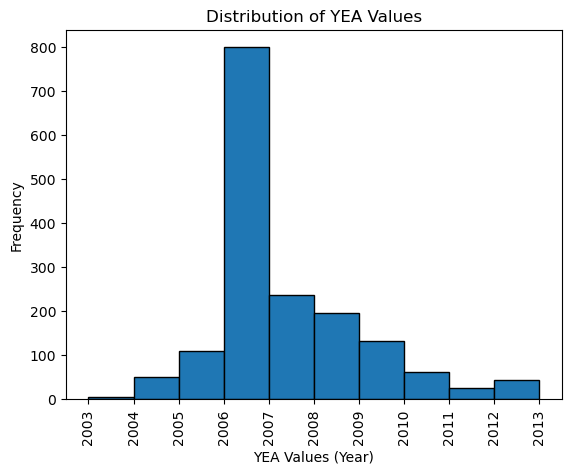

In [23]:
yea_values = empty_or_null_src['YEA']
min_year = min(yea_values)
max_year = max(yea_values)


year_range = max_year - min_year

plt.hist(yea_values, bins=year_range, range=(min_year, max_year), edgecolor='k')
plt.xlabel('YEA Values (Year)')
plt.ylabel('Frequency')
plt.title('Distribution of YEA Values')
plt.xticks(range(min_year, max_year + 1), rotation=90)
plt.show()

We can see that the year 2006 has more missing value, however, this could simply be because that year has more data, and thus also more missing data. We need to check the percentage of missing data by year.

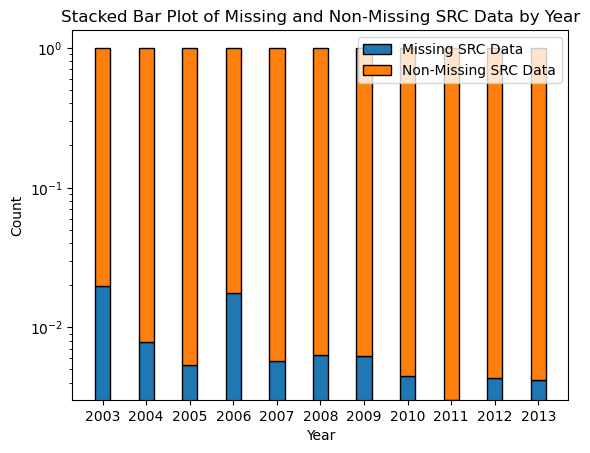

In [24]:
# We get the total number of available (missing or not) data for each year
yearly_data_counts = wiki_df['YEA'].value_counts().sort_index()

# We calculate the percentages of missing data and non missing data.
missing_src_percentages = empty_or_null_src['YEA'].value_counts().sort_index() / yearly_data_counts
non_missing_src_percentages = non_empty_or_null_src['YEA'].value_counts().sort_index() / yearly_data_counts

# We create a stacked bar plot
fig, ax = plt.subplots()
bar_width = 0.35
years = yearly_data_counts.index


plt.bar(years, missing_src_percentages, bar_width, label='Missing SRC Data', edgecolor='k')
plt.bar(years, non_missing_src_percentages, bar_width, label='Non-Missing SRC Data', edgecolor='k', bottom=missing_src_percentages)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Missing and Non-Missing SRC Data by Year')
plt.xticks(years)
plt.yscale('log')
plt.legend()
plt.show()

We see that indeed there is more missing data for the years 2003 and 2005. Now, back to our initial hypothesis, which is that some part of the file might be corrupted, could it be, that for those years, a big part lies between the indexes where most of the missing data happens?

In [25]:
wiki_df.iloc[150000:170000]['YEA'].unique()

array([2006], dtype=int64)

We notice, that in those indexes, there is only votes corresponding to the year 2006, which might explain the number of missing data.

In all cases, the fact that missing data happens in all years, seems to suggest that it isn't an error of parsing but simply a reality that comes with our dataset.

Now, what do we do with this missing data?


First let's take a look at the amount of missing data

In [26]:
missing_src_percentages * 100

YEA
2003    1.970443
2004    0.779697
2005    0.538564
2006    1.765030
2007    0.570521
2008    0.639785
2009    0.622222
2010    0.450966
2011    0.303880
2012    0.432499
2013    0.419933
Name: count, dtype: float64

We have less than 1% of missing data for all the years except for the years 2003 and 2006 where we have less than 2%.

What to do with data ? _A voir,
mon hypothèse est que la missing data correspond à des utilisateurs qui ont été "bannis" ou autre, on garde leur vote pour justifier le résultat de l'élection mais on jette le reste pour RGPD (comme pour le projet PD avec la suppression de l'utilisateur)
on pourrait voir si ça influence le résultat d'une élection aka comparer les résultats de l'élections avec et sans missing data, voir si un résultat d'election change et voir lequel est affiché dans la colonne RES.
ensuite, j'ai l'impression qu'on pourrait s'en servir pour l'analyse globale des données : nombre de votes, marges de victoire etc..., par contre, pour le reste, ce sera pas utilisable : NLP parce que y'a pas de texte et Graphe psk y'a pas de SRC._

##### Voters Exploration

Let's take a look at the number of unique voters in the dataset.

In [27]:
print(f'Number of unique voters : {len(non_empty_or_null_src["SRC"].unique())}')

Number of unique voters : 10416


In [28]:
print(f'Number of unique members (either voters or candidates) : {len(pd.concat([non_empty_or_null_src["SRC"], wiki_df["TGT"]]).unique())}')

Number of unique members (either voters or candidates) : 11380


We can be more precise and look at the evolution of the number of voters per year. 

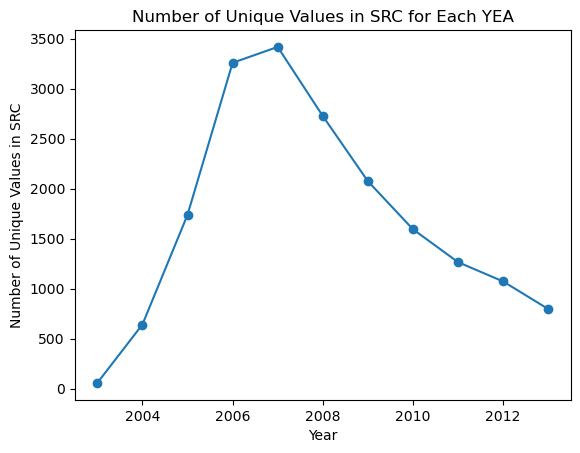

In [29]:
# Group by YEA and count the number of unique SRC
unique_voters_per_year = wiki_df.groupby(wiki_df['YEA'])['SRC'].nunique()

plt.plot(unique_voters_per_year.index, unique_voters_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Unique Values in SRC')
plt.title('Number of Unique Values in SRC for Each YEA')
plt.show()

In [30]:
print(f'Average number of unique voters per year: {unique_voters_per_year.mean(): 0.0f}')

Average number of unique voters per year:  1694


We can see that the number of voters peaks for the years 2006 and 2007 and then slowly decreases again, with an average of 1694 voters per year.

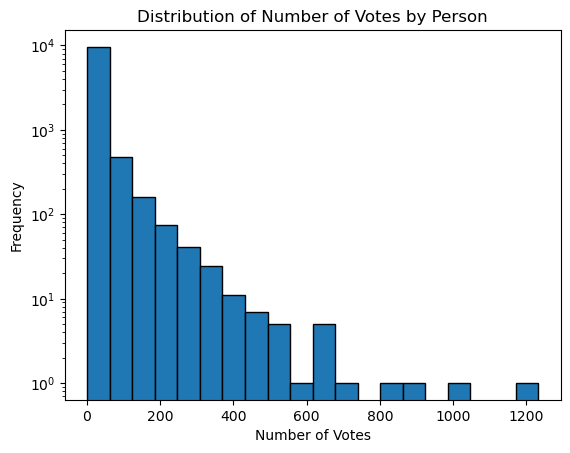

In [31]:
votes_distribution = non_empty_or_null_src['SRC'].value_counts()

plt.hist(votes_distribution, bins=20, edgecolor='k')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Number of Votes by Person')
plt.show()

In [32]:
# Top voters
votes_distribution.head(10)

SRC
Siva1979         1232
Mailer diablo     998
Merovingian       916
Wizardman         810
Acalamari         726
Xoloz             677
Pedro             663
Dlohcierekim      661
Bearian           635
Stifle            628
Name: count, dtype: int64

In [33]:
votes_distribution[votes_distribution > 500]

SRC
Siva1979         1232
Mailer diablo     998
Merovingian       916
Wizardman         810
Acalamari         726
Xoloz             677
Pedro             663
Dlohcierekim      661
Bearian           635
Stifle            628
Jmlk17            567
MONGO             548
Terence Ong       546
Malinaccier       545
Wisdom89          512
Name: count, dtype: int64

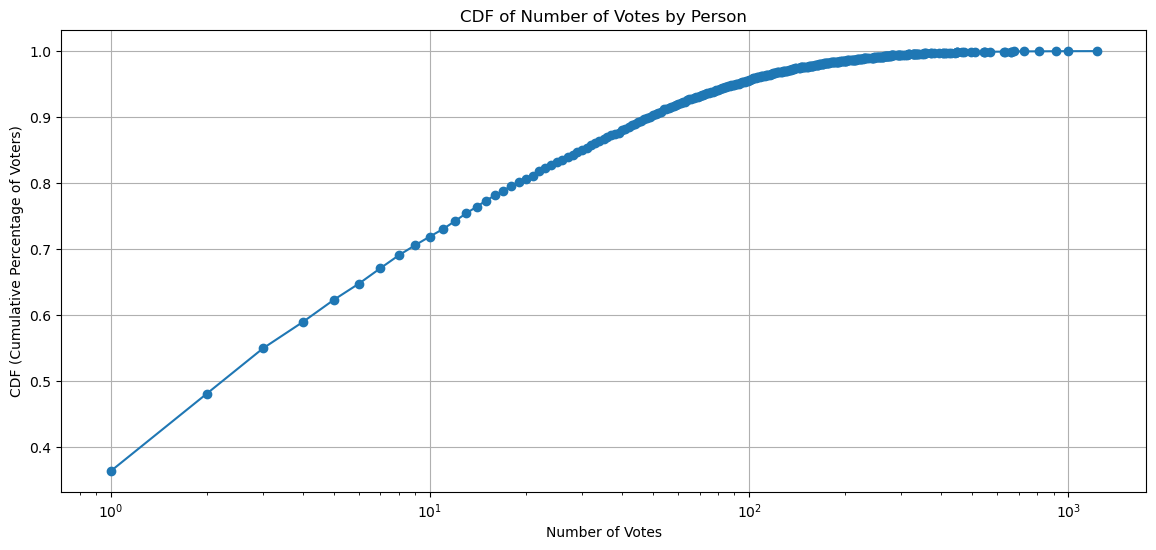

In [34]:
cdf = votes_distribution.value_counts().sort_index().cumsum() / len(votes_distribution) 

plt.figure(figsize=(14, 6))
plt.plot(cdf.index, cdf, marker='o', linestyle='-')
plt.xlabel('Number of Votes')
plt.ylabel('CDF (Cumulative Percentage of Voters)')
plt.title('CDF of Number of Votes by Person')
plt.xscale('log')
plt.grid(True)
plt.show()

In [35]:
cdf

count
1       0.364151
2       0.481375
3       0.550019
4       0.589958
5       0.623464
          ...   
726     0.999616
810     0.999712
916     0.999808
998     0.999904
1232    1.000000
Name: count, Length: 305, dtype: float64

In [36]:
print(f'Median of number of votes per voter: {votes_distribution.value_counts().sort_index().median()}')
print(f'Mean of number of votes per voter: {votes_distribution.value_counts().sort_index().mean()}')

Median of number of votes per voter: 3.0
Mean of number of votes per voter: 34.15081967213115


The plot starts at 0.36 as it shows the percentage that have voted more than 1 times, the 36% left are the people who voted only one time.
We notice thus that half of the voters have voted less than 3 times, and 36% of the voters have only voted one time.
The median of the number of votes per voter is 3 while the mean is 34, showing that our distribution is skewed to the right.

Let's analyse similarity of voters between each pair of years, this will allow us to see if the nature of voters change throughout the year.

In [37]:
# We create a DataFrame with unique voters and their corresponding years
voters_years_df = non_empty_or_null_src[['SRC', 'YEA']].drop_duplicates()
# We group by the voters and the years they voted in
voters_years_grouped = voters_years_df.groupby('SRC')['YEA'].agg(set)
unique_years = voters_years_df['YEA'].unique()

# Storing the results
results_df = pd.DataFrame(index=unique_years, columns=unique_years).astype(float)


In [38]:
for y1 in unique_years:
    for y2 in unique_years:
        if y1 == y2:
            results_df.at[y1, y2] = 1
        else:
            results_df.at[y1, y2] = len(voters_years_grouped[voters_years_grouped.apply(lambda x: y1 in x and y2 in x)].index) / len(voters_years_grouped[voters_years_grouped.apply(lambda x: y1 in x)])


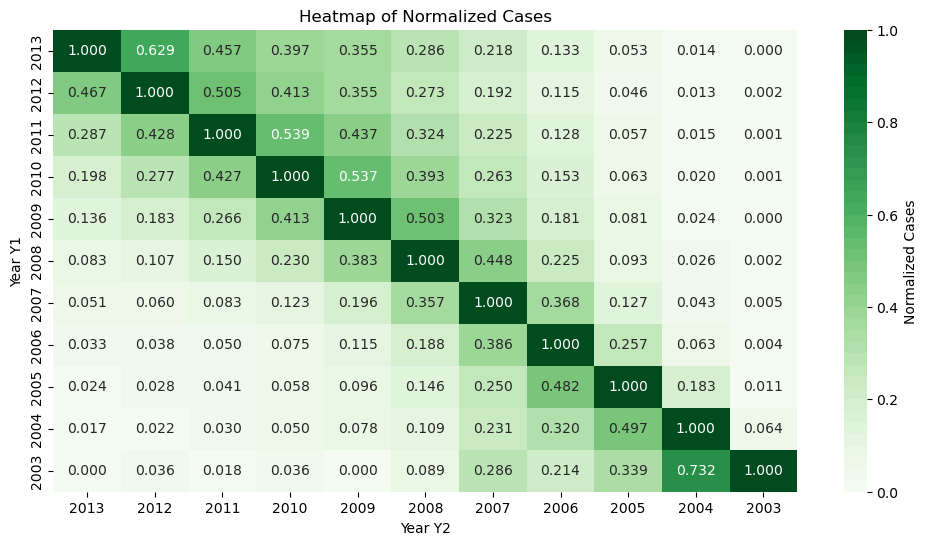

In [39]:
plt.figure(figsize=(12, 6))
sns.heatmap(results_df, cmap=sns.color_palette("Greens",40),annot=True, fmt=".3f", cbar_kws={'label': 'Normalized Cases'})

plt.xlabel('Year Y2')
plt.ylabel('Year Y1')
plt.title('Heatmap of Normalized Cases')

plt.show()

The heatmap reads like this : for a given pair of years ${y}_{i}, y_{j}$, the value in row $i$ and column $j$ is the percentage of voters in year $i$ that have also voted in year $j$.


The heatmap shows us that there is a lot of variability in the voters, and there aren't as many voters that are common between years as one would assume. However, this makes sense considering more than 50\% of voters have voted less than 4 times.

We can see higher values around the diagonal which shows the amount of common voters between close years, as the years drift apart, the number of common voters tend to reduce.

Such a vizualisation is important to see the correlation between the identities of voters between years. Indeed, if we were ever to analyze text used in 2003 and compare it to the text used in 2013, we must be aware that there are no common voters between the two years, the analysis might thus reveal differences not because the language has changed, but rather because there are different voters using different languages.

##### Candidates Exploration

We will now proceed with the same data exploration, but for candidates.

In [40]:
print(f'Number of unique candidates : {len(wiki_df["TGT"].unique())}')

Number of unique candidates : 3497


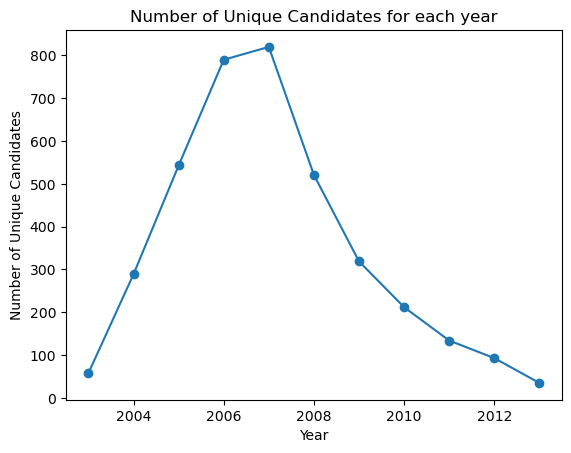

In [41]:
# Group by YEA and count the number of unique SRC
unique_candidates_per_year = wiki_df.groupby(wiki_df['YEA'])['TGT'].nunique()

plt.plot(unique_candidates_per_year.index, unique_candidates_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Unique Candidates')
plt.title('Number of Unique Candidates for each year')
plt.show()

We retrieve a similar distribution to the one for voters. Which means that the number of candidates is correlated to the number of voters. 

However, in order to explore more this side of the data, we need to draw a line between different elections. Indeed, if we wanted to look at the number of times a candidate is running for elections, we need to separate different elections. Fortunately, it seems that in our dataset, the votes are ordered by election and by time, meaning, when a candidate changes in the data, that means that the vote is for a new election.

We use that information to identify different elections.

###### Grouping Elections 

In [42]:
wiki_df['ELECTION_ID'] = 0
current_id = 1

for index, row in wiki_df.iterrows():
    tgt_value = row['TGT']
    
    # Check if the 'TGT' value is different from the previous row
    if index > 0 and wiki_df.at[index - 1, 'TGT'] != tgt_value:
        current_id += 1  # Increment ELECTION_ID for a new 'TGT' value
    
    wiki_df.at[index, 'ELECTION_ID'] = current_id

In [43]:
display(wiki_df)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1
...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support,3926
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.,3927
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --,3927
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....,3927


We have given consecutive rows with the same "TGT" value the same ELECTION_ID value, however, we have not yet verified if there are instances where non-consecutive rows with the same "TGT" value belong to the the same election. To identify this, we will group by ELECTION_ID values and look at groups that have less than 5 voters, as this might signify that there is a problem with the grouping, we will then analyze some of these occurences to see if we can draw any conclusions from them.

In [44]:
grouped_elections = wiki_df.groupby('ELECTION_ID').size()
grouped_elections[grouped_elections <= 5]

ELECTION_ID
70      3
71      5
117     2
125     4
127     3
       ..
3924    5
3925    3
3926    3
3927    3
3928    1
Length: 335, dtype: int64

Let's take the election with id 70 and see why it has so little voters. We will look at the rows with that Election_ID, and then we will look at all rows with that election 'TGT' to see if we are missing some votes.

In [45]:
wiki_df[wiki_df['ELECTION_ID'] == 70]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
7329,Cyberpower678,Baseballrocks538,-1,0,2012,2012-03-06 23:15:00,'''Strongest Oppose''' This user clearly does ...,70
7330,Eagles247,Baseballrocks538,-1,0,2012,2012-03-06 23:16:00,'''Oppose''' per warnings on user's talk page....,70
7331,SarekOfVulcan,Baseballrocks538,-1,0,2012,2012-03-06 23:17:00,"Sorry, but [[WP:NOTYET]]. You need a lot more ...",70


In [46]:
wiki_df[wiki_df['TGT'] == 'Baseballrocks538']

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
7329,Cyberpower678,Baseballrocks538,-1,0,2012,2012-03-06 23:15:00,'''Strongest Oppose''' This user clearly does ...,70
7330,Eagles247,Baseballrocks538,-1,0,2012,2012-03-06 23:16:00,'''Oppose''' per warnings on user's talk page....,70
7331,SarekOfVulcan,Baseballrocks538,-1,0,2012,2012-03-06 23:17:00,"Sorry, but [[WP:NOTYET]]. You need a lot more ...",70


As we can see, it seems that the "Baseballrocks538" has indeed only received three votes, and that it doesn't come from a problem in our grouping.

Let's take an occurence where a same TGT corresponds to more than one ELECTION_ID, and analyse the two election groups.

In [47]:
# We count the number of ELECTION_ID each 'TGT' belongs to
unique_election_id_counts = wiki_df.groupby('TGT')['ELECTION_ID'].nunique()

In [48]:
unique_election_id_counts[unique_election_id_counts > 2]

TGT
Carnildo             3
Cobi                 3
Cool3                3
Curtis23             3
Elonka               3
Enigmaman            3
Everyking            6
Firefoxman           3
Footballfan190       3
Geni                 3
Guanaco              4
HJ Mitchell          3
Hex                  3
Ironholds            4
Juliancolton         3
Ktr101               4
Kww                  3
Leonard^Bloom        3
MONGO                3
MZMcBride            4
MoRsE                3
Porchcrop            3
Richardcavell        3
Robchurch            3
ST47                 3
Sceptre              3
Shoessss             3
Slon02               3
TenPoundHammer       3
The Transhumanist    4
Thumperward          3
Werdna               3
Wikiwoohoo           4
ZooPro               3
^demon               3
Name: ELECTION_ID, dtype: int64

Let's take the user 'Carnildo' for instance and look at the different election groups to which he belongs.

In [49]:
carnildo_df = wiki_df[(wiki_df['TGT'] == 'Carnildo')]
carnildo_df['ELECTION_ID'].unique()

array([2239, 2608, 3064], dtype=int64)

In [50]:
carnildo_df[carnildo_df['ELECTION_ID'] == 2239].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
129888,UninvitedCompany,Carnildo,1,1,2006,2006-08-18 22:48:00,,2239
129889,Chacor,Carnildo,1,1,2006,2006-08-29 03:05:00,"This is bound to be a controversial RFA, but e...",2239
129890,crazytales56297,Carnildo,1,1,2006,2006-08-29 03:07:00,'''Support''' per Chacor. <!--begin crazytales...,2239
129891,Sean Black,Carnildo,1,1,2006,2006-08-29 03:09:00,--[[Special:Contributions/Sean Black|SB]] |,2239
129892,Mindspillage,Carnildo,1,1,2006,2006-08-29 03:20:00,'''Support'''. I believe the incident for whic...,2239


In [51]:
carnildo_df[carnildo_df['ELECTION_ID'] == 2608].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
155749,Jahiegel,Carnildo,1,0,2006,2006-03-20 21:36:00,I've been waiting for Carnildo to accept and a...,2608
155750,RN,Carnildo,1,0,2006,2006-03-20 22:06:00,[[Image:Symbol support vote.svg|15px]] '''Supp...,2608
155751,BD2412,Carnildo,1,0,2006,2006-03-20 22:11:00,"''NEVER!!!'' Oh, wait, this is ''[[User:Carnil...",2608
155752,Rune.welsh,Carnildo,1,0,2006,2006-03-20 22:28:00,'''Strong support'''. His work regarding image...,2608
155753,Alhutch,Carnildo,1,0,2006,2006-03-20 22:43:00,'''Support''' per Rune. good user.--,2608


In [52]:
carnildo_df[carnildo_df['ELECTION_ID'] == 3064].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
173443,Redwolf24,Carnildo,1,1,2005,2005-08-13 01:34:00,"<font size=""+2"">SUPPORT!</font>",3064
173444,Starblind,Carnildo,1,1,2005,NaT,"'''Strong Support''' Excellent editor, strong ...",3064
173445,RN,Carnildo,1,1,2005,2005-08-13 03:57:00,'''Strong Support''' He can be a bit confrenta...,3064
173446,Denelson83,Carnildo,1,1,2005,2005-08-13 06:06:00,"'''Support!''' Support! Support! <span style=""...",3064
173447,Merovingian,Carnildo,1,1,2005,NaT,,3064


As we can see, the different ELECTION_ID correspond indeed to different elections.

We can also notice that a candidate can run for elections multiple times, even in the same year, which is why it is important to group elections in the order they appear in rather than taking the "YEA" column value for instance. Moreover, we notice that a candidate can run another time, even after winning an election, which is an odd occurence as adminship is supposed to be a definitive status, so how can it be that someone can run for adminship again, even after supposedly being elected the first time.

Let's see how many times that occur. We first group by elections, and then group by candidate, summing the results of the election. If the value is greater than 1, than means the candidate has won more than 1 election.

In [53]:
# Step 1 : Grouping the elections
grouped_elections = wiki_df[['ELECTION_ID', 'RES', 'TGT']].drop_duplicates()
# Step 2 : Summing the 'RES' values
won_elections = grouped_elections.groupby('TGT')['RES'].sum()

In [54]:
print(f'Number of candidates having won more than one election: {len(won_elections[won_elections > 1])}\n')
display(won_elections[won_elections > 1])

Number of candidates having won more than one election: 18



TGT
Carnildo           2
Croat Canuck       2
Danny              2
Evercat            2
Everyking          2
Geni               2
Guanaco            2
HJ Mitchell        2
MZMcBride          2
Nev1               2
PMelvilleAustin    2
PeterSymonds       2
SarekOfVulcan      2
Sarge Baldy        2
Sean Black         2
Ugen64             2
W.marsh            2
^demon             2
Name: RES, dtype: int64

As we can see, there are 18 candidates who have one more than one election (precisely, two elections).

A quick look at Carnildo's history, shows us that he has been 'resysopped', meaning reelected (cf: https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_Signpost/2006-09-11/Carnildo_resysopped), which explains the fact that he has won two elections.

In fact, we can all the candidates in the list were reelected as well, as their names can be found in Wikipedia's list of resysopped users: "https://en.wikipedia.org/wiki/Wikipedia:List_of_resysopped_users ".

###### Election Analysis

Now that we have successfully identified distinct elections, let's look at some statistics about the elections. First, let's group the elections, counting the number and the percentage of positive, negative and neutral votes.

In [55]:
elections_df = wiki_df.groupby(['ELECTION_ID', 'TGT', 'RES', 'YEA']).agg(
    positive_votes=('VOT', lambda x: (x == 1).sum()),
    neutral_votes=('VOT', lambda x: (x == 0).sum()),
    negative_votes=('VOT', lambda x: (x == -1).sum()),
    total_votes=('VOT', 'count'),
).reset_index()

elections_df['positive_percentage'] = (elections_df['positive_votes'] / elections_df['total_votes']) * 100
elections_df['neutral_percentage'] = (elections_df['neutral_votes'] / elections_df['total_votes']) * 100
elections_df['negative_percentage'] = (elections_df['negative_votes'] / elections_df['total_votes']) * 100

In [56]:
elections_df.head(10)

,ELECTION_ID,TGT,RES,YEA,positive_votes,neutral_votes,negative_votes,total_votes,positive_percentage,neutral_percentage,negative_percentage
0,1,BDD,1,2013,119,4,14,137,86.861314,2.919708,10.218978
1,2,Bilby,1,2013,134,1,2,137,97.810219,0.729927,1.459854
2,3,Darkwind,1,2013,108,8,30,146,73.972603,5.479452,20.547945
3,4,INeverCry,1,2013,101,1,8,110,91.818182,0.909091,7.272727
4,5,Jason Quinn,1,2013,138,16,29,183,75.409836,8.743169,15.846995
5,6,Legoktm,1,2013,149,4,3,156,95.512821,2.564103,1.923077
6,7,Lord Roem,1,2013,138,3,13,154,89.610390,1.948052,8.441558
7,8,Mattythewhite,1,2013,102,4,8,114,89.473684,3.508772,7.017544
8,9,Miniapolis,1,2013,84,7,24,115,73.043478,6.086957,20.869565
9,10,Mkdw,1,2013,104,2,1,107,97.196262,1.869159,0.934579


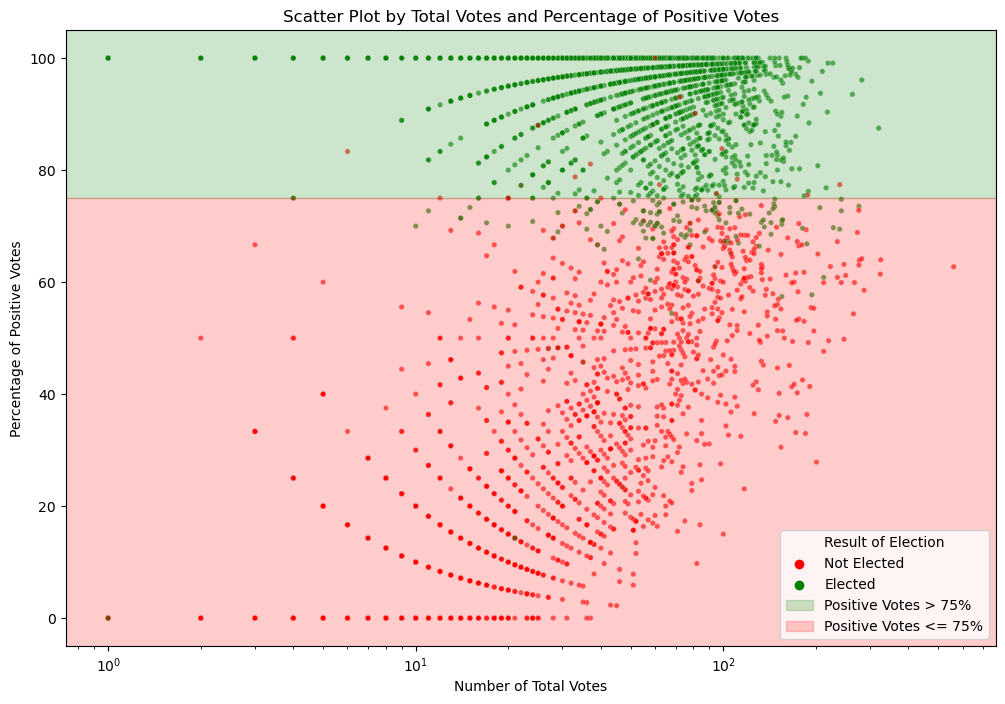

In [57]:
# Assuming 'total_votes', 'positive_percentage', and 'RES' are the columns in elections_df
plt.figure(figsize=(12, 8))

# Scatter plot with points colored by the percentage of positive votes
scatter = sns.scatterplot(x='total_votes', y='positive_percentage', hue='RES', data=elections_df, palette={0: 'red', 1: 'green'}, s=15, alpha=0.6)

plt.axhspan(75, 105, color='green', alpha=0.2, label='Positive Votes > 75%')
plt.axhspan(-5, 75, color='red', alpha=0.2, label='Positive Votes <= 75%')

plt.title('Scatter Plot by Total Votes and Percentage of Positive Votes')
plt.xlabel('Number of Total Votes')
plt.ylabel('Percentage of Positive Votes')
plt.ylim(-5, 105)
plt.xscale('log')
plt.legend(title='Result of Election', loc='upper right', labels=['Not Elected', 'Elected'])

# Adjust the legend
handles, labels = scatter.get_legend_handles_labels()
labels[0] = 'Not Elected'
labels[1] = 'Elected'
scatter.legend(handles, labels, title='Result of Election', loc='lower right')

plt.show()

The wikipedia article about RfA elections states : "Consensus at RfA is not determined by surpassing a numerical threshold, but by the strength of rationales presented. In practice, most RfAs above 75% support pass." (https://en.wikipedia.org/wiki/Wikipedia:Requests_for_adminship).

The treshold is indeed noticeable, however, the plot shows that it is a bit below 75%. We can also notice that there are some exceptions that have a very high positive votes percentage, yet end up not being elected, and vice-versa. Which echoes the fact that a certain percentage of votes is not a guarantee of a successful election. However, the opposite seems to be true, indeed, for the vast majority of cases, it seems that having less than 50% of positive votes is a guarantee of failing the election.

Let's look at two points that particularly stand out in the plot : the one in the lower left corner, having 0% of positive votes yet being elected, and the red dot having a 100% of positive votes and being rejected.

In [58]:
elections_df[(elections_df['positive_percentage'] == 100) & (elections_df['RES'] == 0)]

,ELECTION_ID,TGT,RES,YEA,positive_votes,neutral_votes,negative_votes,total_votes,positive_percentage,neutral_percentage,negative_percentage
1193,1194,matt037291,0,2008,1,0,0,1,100.0,0.0,0.0
2003,2004,Moralis,0,2007,1,0,0,1,100.0,0.0,0.0
2787,2788,LtPowers,0,2006,1,0,0,1,100.0,0.0,0.0
2793,2794,madcowpoo,0,2006,14,0,0,14,100.0,0.0,0.0
2950,2951,The Fish,0,2006,13,0,0,13,100.0,0.0,0.0
2988,2989,Weyes3,0,2006,1,0,0,1,100.0,0.0,0.0
3478,3479,Ilmari Karonen,0,2005,1,0,0,1,100.0,0.0,0.0
3483,3484,"Just zis Guy, you know?",0,2005,1,0,0,1,100.0,0.0,0.0
3494,3495,MarkGallagher,0,2005,2,0,0,2,100.0,0.0,0.0
3526,3527,Robchurch,0,2005,60,0,0,60,100.0,0.0,0.0


In [59]:
wiki_df[wiki_df['TGT'] == 'Robchurch']

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
165923,Musical Linguist,Robchurch,1,0,2006,2005-12-28 14:07:00,The nominator [[User:NicholasTurnbull|Nicholas...,2883
165924,Bishonen,Robchurch,1,0,2006,2005-12-28 00:14:00,I can't believe he wasn't already an admin. Oh...,2883
165925,Mysekurity,Robchurch,1,0,2006,2005-12-28 00:14:00,"Ditto Bish. -[[User:Mysekurity|<font color=""bl...",2883
165926,Rx StrangeLove,Robchurch,1,0,2006,2005-12-28 00:16:00,'''Support''' Everything Nicholas says is true...,2883
165927,Jtkiefer,Robchurch,1,0,2006,2005-12-28 00:17:00,(after 3 edit conflicts) I'm sure he'll make g...,2883
...,...,...,...,...,...,...,...,...
189967,ABCD,Robchurch,1,0,2005,2005-10-16 04:16:00,"""'''Support'''. $user is not an admin?"" &ndash;",3527
189968,bmicomp,Robchurch,1,0,2005,2005-10-16 20:27:00,'''Support!''' -- [[User:Bmicomp|BMIComp]] [[U...,3527
189969,Linuxbeak,Robchurch,1,0,2005,2005-10-16 22:40:00,'''Support'''. I could have sworn that I had v...,3527
189970,Francs2000,Robchurch,1,0,2005,2005-10-16 23:44:00,"'''Very strong support''', a very fine editor --",3527


### Dataframes

Now that we have processed the data, we will create new dataframes containing statistics about the individuals and the elections that can be directly used when working with the data.

Let's start with the elections, we group the same elections and, as we did earlier, get the :
- Candidate
- Year
- Number of positive, neutral and negative votes.
- Percentage of positive, neutral and negative votes.
- Total number of votes
- Earliest and latest voting date.

For this, we define a function that directly does the grouping and the aggregation.

In [71]:
elections_df = create_elections_df(wiki_df)

In [72]:
elections_df.head(5)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00


Now, we create a dataframe that contains information the following information about users :
- The number of times they voted
- The number of times they run for an election
- The number of times they won
- The number of times they lost
- The years they were active in
- The percentage of positive votes they casted
- The percentage of negative votes they casted
- The percentage of neutral votes they casted
- The difference between the result of the election and their vote

In [79]:
candidates_df = create_candidates_df(wiki_df)

In [80]:
candidates_df

,TGT,Number of Elections,Won Elections,Lost Elections,Votes Received,Positive Percentage,Negative Percentage,Neutral Percentage,Average Length Received
0,(aeropagitica),1,1,0,55,0.727273,0.181818,0.090909,106.672727
1,07bargem,1,0,1,6,0.000000,1.000000,0.000000,278.500000
2,1234r00t,1,0,1,6,0.000000,1.000000,0.000000,275.333333
3,168...,1,1,0,7,1.000000,0.000000,0.000000,42.000000
4,21655,1,0,1,24,0.166667,0.750000,0.083333,324.833333
...,...,...,...,...,...,...,...,...,...
3492,zeuspitar,1,0,1,3,0.333333,0.666667,0.000000,230.000000
3493,zhudyzhu,1,0,1,2,0.000000,1.000000,0.000000,353.000000
3494,Ævar Arnfjörð Bjarmason,2,1,1,96,0.625000,0.333333,0.041667,143.542998
3495,Σ,1,0,1,223,0.627803,0.291480,0.080717,240.381166


In [64]:
voters_df = create_voters_df(wiki_df)

In [65]:
voters_df

,USER,Active Years,Votes Count,Positive Percentage,Negative Percentage,Neutral Percentage,Voted Differently,Voted Similarly
0,!---slappdash---!,[2009],1,100.000000,0.000000,0.0,0.000000,100.000000
1,%D0%90,[2006],13,100.000000,0.000000,0.0,15.384615,84.615385
2,'sed,[2006],3,100.000000,0.000000,0.0,66.666667,33.333333
3,(.Y.),[2006],1,100.000000,0.000000,0.0,0.000000,100.000000
4,(:Julien:),[2005],1,100.000000,0.000000,0.0,0.000000,100.000000
...,...,...,...,...,...,...,...,...
10411,とある白い猫,[2013],1,100.000000,0.000000,0.0,0.000000,100.000000
10412,シ,[2010],6,66.666667,33.333333,0.0,50.000000,50.000000
10413,石,[2012],1,100.000000,0.000000,0.0,0.000000,100.000000
10414,龗,[2009],2,50.000000,50.000000,0.0,50.000000,50.000000
